## Experimenting with implementation
- general form of (2) in ODE2ODE, may also be useful later
- iso-ODE2ODE

Step: 0, Loss: 0.21598659455776215, Computation time: 28.34232211112976
Step: 100, Loss: 0.024925565347075462, Computation time: 0.02775859832763672
Step: 199, Loss: 0.011636133305728436, Computation time: 0.02695941925048828
Step: 0, Loss: 0.0165034718811512, Computation time: 0.02533721923828125
Step: 100, Loss: 0.02304108440876007, Computation time: 0.0244905948638916
Step: 199, Loss: 0.01231281366199255, Computation time: 0.03979086875915527


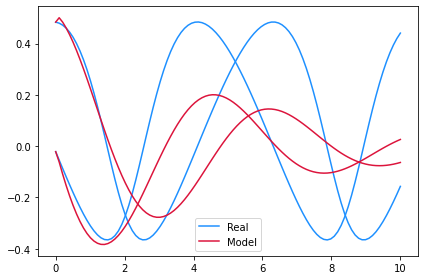

In [15]:
import time

import jax 
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jrandom 
from functools import partial
from jax import jit

import diffrax
import equinox as eqx

import matplotlib.pyplot as plt

import optax

import copy

import joblib

from WeightDynamics import * 



class DynX(eqx.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

    def __call__(self, x):
        return x

class Func(eqx.Module):
    b: WeightDynamics
    f: DynX
    d: int

    def __init__(self, b, f, **kwargs):
        super().__init__(**kwargs)
        # dynamics by which W_t should evolve
        self.b = b
        self.d = b.d # dimension of x_t
        # dynamics by which x_t should evolve
        self.f = f

    def __call__(self, t, y, args):
        d = self.d
        x = y[:d] 
        W = jnp.reshape(y[d:], newshape=(d, d))
        f = self.f(jnp.matmul(W, x))
        bw = jnp.matmul(W, self.b(W))
        
        return jnp.concatenate([f, jnp.reshape(bw, newshape=(d*d))], axis=0)

class NeuralODE(eqx.Module):
    func: Func
    num_steps: list 

    def __init__(self, b, **kwargs):
        super().__init__(**kwargs)
        f = DynX()
        self.func = Func(b, f, **kwargs)
        self.num_steps = []

    def __call__(self, ts, y0): 
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(),
            saveat=diffrax.SaveAt(ts=ts),
        )
        num_steps = solution.stats['num_steps']
        self.num_steps.append(num_steps)
        return solution.ys

def _get_data(ts, *, key):
    y0 = jrandom.uniform(key, (2,), minval=-0.6, maxval=1)

    def f(t, y, args):
        x = y / (1 + y)
        return jnp.stack([x[1], -x[0]], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.1
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 10, 100)
    key = jrandom.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

def dataloader(arrays, batch_size, *, key):
    dataset_size, n_timestamps, n_dim = arrays[0].shape
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    # we concatenate some orthogonal matrix to the state, as we use one dynamical system
    # to describe how the weights and state evolves
    cat = jnp.reshape(jnp.concatenate([jnp.eye(n_dim)]*batch_size*n_timestamps), newshape=(batch_size, n_timestamps, n_dim**2))
    # a = 1/jnp.sqrt(2)
    # b = -a
    # cat = jnp.reshape(jnp.concatenate([jnp.array([[a, b], [-b, a]])]*batch_size*n_timestamps), newshape=(batch_size, n_timestamps, n_dim**2))
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(jnp.concatenate([array[batch_perm], cat], axis=-1) for array in arrays)
            start = end
            end = start + batch_size

def main(
    dataset_size=256,
    batch_size=32,
    lr_strategy=(3e-3, 3e-3),
    steps_strategy=(500, 500),
    length_strategy=(0.1, 1),
    seed=5678,
    plot=True,
    print_every=100,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    ts, ys = get_data(dataset_size, key=data_key)
    _, length_size, data_size = ys.shape

    b = GatedODE(data_size, width=10, depth=2, key=key)
    model = NeuralODE(b=b)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        # test_call = model(ti, yi[0, 0])
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0, :]) 
        return jnp.mean((yi[:, :, :2] - y_pred[:, :, :2]) ** 2) 

    # @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        # old_model = copy.deepcopy(model)
        model = eqx.apply_updates(model, updates)
        # print(repr(old_model.func.b._Q - model.func.b._Q[0, 0])) # this is traced if we use @eqx.filter_jit
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adabelief(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)] # length is the fraction of timestamps on which we train
        for step, (yi,) in zip( 
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    if plot:
        plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
        plt.plot(ts, ys[0, :, 1], c="dodgerblue")
        model_y = model(ts, jnp.concatenate([ys[0, 0], jnp.array([1, 0, 0, 1])]))
        plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
        plt.plot(ts, model_y[:, 1], c="crimson")
        plt.legend()
        plt.tight_layout()
        plt.savefig("neural_ode2ode.png")
        plt.show()

    return ts, ys, model


ts, ys, model = main(
    steps_strategy=(200, 200),
    print_every=100,
    length_strategy=(.1, .1),
    lr_strategy=(3e-3, 3e-3),
)

In [13]:
print(model.num_steps)

[DeviceArray(44, dtype=int32, weak_type=True)]


In [14]:
print(model.num_steps[0][0])

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.